In [4]:
import pandas as pd
import itertools
import numpy as np

In [5]:
def union(l1,l2):
    union = l1 + l2
    return list(dict.fromkeys(union))

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3


def test_rule(df,rule):
    word = 0
    morewords = 0
    for i in df:
        if rule[0] in i[0]:
            word += 1
            if rule in i[0]:
                morewords += 1
    return morewords/word


def bottom_up(S):

    T = []

    for i in range(len(S)):

        Ti = []

        for j in range(i+1, len(S)):

            atom1 = S[i][0]
            atom2 = S[j][0]
            R = union(atom1,atom2)
            trans_atom1 = S[i][1]
            trans_atom2 = S[j][1]          
            trans_R = intersection(trans_atom1,trans_atom2)
            support = round(len(trans_R)/ntrans,7)
            if support >= minsup:
                Ti.append([R,trans_R])
                F[len(R)].append(R)

        T.append(Ti)
    
    for i in T:
        if i != []:
            bottom_up(i)
            

In [6]:
#data is from https://www.kaggle.com/c/instacart-market-basket-analysis/data
#i dont think we can share it on git, and its too big anyways
order_products_train = pd.read_csv("instacart-market-basket-analysis/order_products__train.csv")
products = pd.read_csv("instacart-market-basket-analysis/products.csv")

def get_product_name(product_id):
    return products[products["product_id"] == product_id]["product_name"].tolist()[0]

def get_order_products(order_id):
    return order_products_train[order_products_train["order_id"] == order_id]["product_id"].tolist()


def get_order_products_names(order_id):
    return list(map(get_product_name,get_order_products(order_id)))

def get_order_ids_for_product(product_id):
    return order_products_train[order_products_train["product_id"] == product_id]["order_id"].tolist()

def get_total_trans(df):
    temp = list(df["transactions"].values)
    flat_temp = [item for sublist in temp for item in sublist]
    return len(list(dict.fromkeys(flat_temp)))

#order_products_train = order_products_train.head(1000000)
#Plot 1: 500k 750k 1m, mätning tid
#Plot 2: 500k rader , support 0.005 0.01, 0.05, 0.1, mätning i tid


order_products_train


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [7]:
data_100k = order_products_train.groupby('order_id')['product_id'].apply(list).reset_index(name='products')
data_100k_T = order_products_train.groupby('product_id')['order_id'].apply(list).reset_index(name='transactions')


data_100k_T["transactions"] = data_100k_T["transactions"].apply(lambda x: sorted(x))
data_100k["products"] = data_100k["products"].apply(lambda x: sorted(x))


In [8]:
data_100k


,order_id,products
0,1,"[10246, 11109, 13176, 22035, 43633, 47209, 493..."
1,36,"[19660, 34497, 39612, 43086, 46620, 46979, 486..."
2,38,"[4461, 11913, 18159, 21616, 23622, 28842, 3243..."
3,96,"[20574, 24489, 25610, 27966, 30391, 39275, 40706]"
4,98,"[329, 790, 1939, 3880, 4357, 7461, 8859, 9373,..."
...,...,...
131204,3421049,"[17299, 17706, 26800, 33424, 34243, 40800]"
131205,3421056,"[5750, 9340, 12432, 16475, 21709]"
131206,3421058,"[4347, 6244, 6858, 15629, 30316, 32650, 34466,..."
131207,3421063,"[13565, 14233, 35548, 49235]"


In [9]:
data_100k_T

,product_id,transactions
0,1,"[6695, 48361, 63770, 75339, 240996, 253400, 25..."
1,2,"[1455635, 1550225, 2481009, 3288051]"
2,3,"[72425, 489378, 1176592, 2188727, 2339119, 274..."
3,4,"[317499, 459014, 508627, 732095, 770868, 83772..."
4,5,[1854678]
...,...,...
39118,49682,"[679895, 1930039, 2165322, 2221196, 3122234]"
39119,49683,"[1, 1335, 4726, 6552, 6861, 6935, 11282, 13038..."
39120,49686,"[133700, 367913, 674266, 1258283, 2133651, 283..."
39121,49687,[1092104]


In [10]:
#Plot 1: 500k 750k 1m, mätning tid
import time
N = [5000]#,10000,25000,50000,100000,250000,500000]#750000,1000000]
time_plot1 = []
transplot = []
for n in N:
    data_temp = order_products_train.head(n)
    data_100k = data_temp.groupby('order_id')['product_id'].apply(list).reset_index(name='products')
    data_100k_T = data_temp.groupby('product_id')['order_id'].apply(list).reset_index(name='transactions')


    data_100k_T["transactions"] = data_100k_T["transactions"].apply(lambda x: sorted(x))
    data_100k["products"] = data_100k["products"].apply(lambda x: sorted(x))


    eclat_processed = [[[data_100k_T.iloc[i][0]],data_100k_T.iloc[i]["transactions"]] for i in range(len(data_100k_T))]
    max_k = 100
    F = [[] for i in range(max_k)]
    ntrans = len(data_100k)
    transplot.append(ntrans)
    minsup = 0.01
    start = time.time()
    bottom_up(eclat_processed) 
    #eclat_processed
    end = time.time()
    time_plot1.append(end-start)
    print("Time for n = ",n,": ",end-start)



Time for n =  5000 :  7.796705961227417


In [12]:
#Plot 2:  mätning tid
import time
list_support = [0.01]#,0.005]
time_plot2 = []
f_list = []
f_list_2 = []
data_temp = order_products_train.head(100000)
for nsupp in list_support:
    #order_products_train = order_products_train.head(500000)
    data_100k = data_temp.groupby('order_id')['product_id'].apply(list).reset_index(name='products')
    data_100k_T = data_temp.groupby('product_id')['order_id'].apply(list).reset_index(name='transactions')


    data_100k_T["transactions"] = data_100k_T["transactions"].apply(lambda x: sorted(x))
    data_100k["products"] = data_100k["products"].apply(lambda x: sorted(x))


    eclat_processed = [[[data_100k_T.iloc[i][0]],data_100k_T.iloc[i]["transactions"]] for i in range(len(data_100k_T))]
    max_k = 100
    F = [[] for i in range(max_k)]
    ntrans = len(data_100k)
    minsup = nsupp
    start = time.time()
    bottom_up(eclat_processed) 
    #eclat_processed
    end = time.time()
    time_plot2.append(end-start)
    print("Time for n = ",100000,": ",end-start)
    f_list_2.append(F)




Time for n =  100000 :  321.52632308006287


In [13]:
#the rules
F

[[],
 [],
 [[13176, 21137],
  [13176, 21903],
  [13176, 27966],
  [13176, 30391],
  [13176, 47209],
  [13176, 47626],
  [16797, 24852],
  [21137, 21903],
  [21137, 24852],
  [21137, 27966],
  [21137, 39275],
  [21137, 47209],
  [21903, 24852],
  [21903, 47626],
  [21903, 47766],
  [24852, 45066],
  [24852, 47626],
  [24852, 47766],
  [26209, 47626],
  [47626, 47766]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [14]:
f_list_2

[[[],
  [],
  [[13176, 21137],
   [13176, 21903],
   [13176, 27966],
   [13176, 30391],
   [13176, 47209],
   [13176, 47626],
   [16797, 24852],
   [21137, 21903],
   [21137, 24852],
   [21137, 27966],
   [21137, 39275],
   [21137, 47209],
   [21903, 24852],
   [21903, 47626],
   [21903, 47766],
   [24852, 45066],
   [24852, 47626],
   [24852, 47766],
   [26209, 47626],
   [47626, 47766]],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []]]

In [15]:
print(time_plot1)
print(transplot)
print(time_plot2)

[7.796705961227417]
[479]
[321.52632308006287]


# CODE FOR PLOTS

In [ ]:
#Number of transactions = 9477
supp_list = [0.01,0.005,0.001,0.0005] #support used in loop that had N=100000 (9477 transactions)
supp_list_time = [318.83,318.2,299.5,308.73] #time list for each support
transplot = [479, 939, 2356, 4774, 9477, 23648, 47498] #Number of transactions
N = [5000,10000,25000,50000,100000,250000,500000] #Number of rows used, see transplot for corresponding number of transactions
time_plot1 = [7.45, 21.97, 71.14, 163.74, 339.05, 995.37, 2485.06] #seconds
df_plot = pd.DataFrame({"N":N,"Number of transactions":transplot,"Time_plot1":time_plot1})

df_supp_plot = pd.DataFrame({"Support":supp_list,"Time_plot_supp":supp_list_time})

In [ ]:
df_plot

,N,Number of transactions,Time_plot1
0,5000,479,7.457778
1,10000,939,21.979436
2,25000,2356,71.142152
3,50000,4774,163.748016
4,100000,9477,339.057873
5,250000,23648,995.376817
6,500000,47498,2485.068012


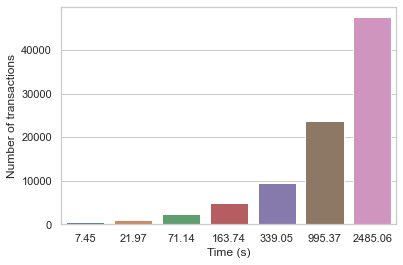

In [ ]:
#plot df_plot as a bar plot
########## Copilot is crazy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="Time_plot1", y="Number of transactions", data=df_plot)
#ax = sns.barplot(x="Time_plot1", y="Number of transactions", data=df_plot)
ax.set(ylabel='Number of transactions', xlabel='Time (s)')
plt.show()


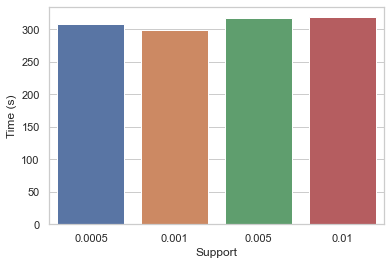

In [ ]:

#plot df_supp_plot as a bar plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="Support", y="Time_plot_supp", data=df_supp_plot)
ax.set(ylabel='Time (s)', xlabel='Support')
plt.show()